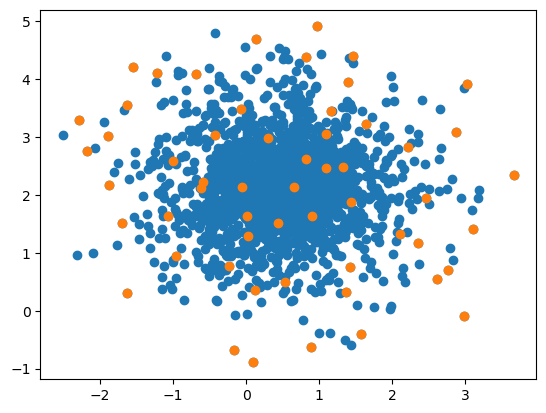

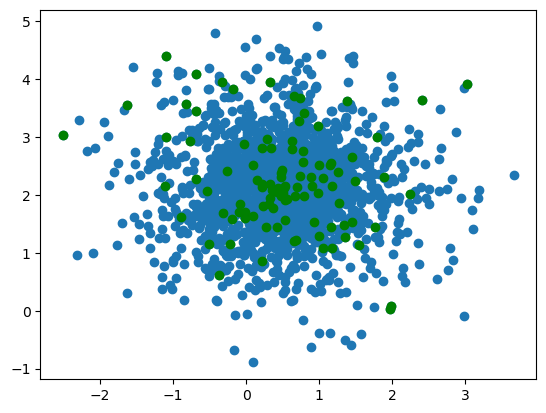

In [15]:
import numpy as np
from scipy.linalg import eigh
from sklearn.datasets import make_blobs
from dppy.finite_dpps import FiniteDPP


def generate_rff_matrix(X, tau, num_features):
    n, d = X.shape
    omega = np.random.normal(size=(d, num_features)) / np.sqrt(tau)
    #use laplace distribution
    omega = np.random.laplace(size=(d, num_features)) / np.sqrt(tau)
    b = 2 * np.pi * np.random.rand(num_features)
    cos_component = np.cos(X @ omega + b)  
    sin_component = np.sin(X @ omega + b)  
    rff_matrix = np.empty((2*num_features, n))
    rff_matrix[:num_features, :] = cos_component.T
    rff_matrix[num_features:, :] = sin_component.T
    return rff_matrix

def compute_dpp_sample(rff_matrix, num_samples):
    gram_matrix = rff_matrix @ rff_matrix.T
    L_enc= rff_matrix.T @ rff_matrix
    dpp_L = FiniteDPP('likelihood', **{'L': L_enc})
    # print(dpp_L.sample_exact())
    return dpp_L.sample_exact(),np.ones(num_samples)

def dpp_coreset(X, tau, num_samples):
    r = 2*num_samples 
    rff_matrix = generate_rff_matrix(X, tau, r)
    sampled_indices,weights = compute_dpp_sample(rff_matrix, num_samples)
    # print(sampled_indices)
    sampled_indices=list(sampled_indices)
    return X[sampled_indices], weights,sampled_indices

def make_dense_blobs(n_samples, centers, cluster_std, center_box):
    X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, center_box=center_box, random_state=0)
    center = np.mean(X, axis=0)
    X_dense = np.vstack([X, np.random.normal(center, cluster_std / 2, size=(n_samples, X.shape[1]))])
    return X_dense

cluster_std = 1.0
center_box = (-5, 5)
X = make_dense_blobs(n_samples=1000, centers=1, cluster_std=1.0, center_box=(-5,5))
tau = 1.5
m = 100
sampled_points, weights,_= dpp_coreset(X, tau, m)
rX=[]
random_indices=np.random.choice(X.shape[0], m, replace=False)
for i in random_indices:
    rX.append(X[i])
#plot the sampled points
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],label='Original Data')
plt.scatter(sampled_points[:,0],sampled_points[:,1],label='Sampled Points')

plt.show()
plt.scatter(X[:,0],X[:,1],label='Original Data')
plt.scatter(np.array(rX)[:,0],np.array(rX)[:,1],label='Random Points',color='green')
plt.show()

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

torch.manual_seed(0)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, weights, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        # for x in enumerate(train_loader):
        #     print(x)
        i=0
        for images, labels in train_loader:
            optimizer.zero_grad()
            # print(images.shape)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            i+=1
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
def train_model_weigths(model, train_loader, criterion, optimizer,weight,len, num_epochs=40):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            images = images.float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        
def train_model2(model, train_loader, criterion, optimizer, num_epochs=5):
    # Assuming `train_loader` is set up to load Fashion MNIST data
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Reshape images to [batch_size, 1, 28, 28]
            images = images.view(-1, 1, 28, 28)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [20]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data=train_data[:5000]

In [21]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [22]:
# Extract a subset of data_points from the Fashion MNIST dataset
import numpy as np

data_points = []
labels_list = []
for images, labels in train_loader:
    flattened_images = images.view(images.size(0), -1).numpy()
    data_points.extend(flattened_images)
    labels_list.extend(labels.numpy())

data_points = np.array(data_points)  
labels_list = np.array(labels_list) 
print(data_points.shape)
print(labels_list.shape)

(5000, 784)
(5000,)


In [23]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [24]:
accuracies_coreset=[]
dummy_accuracies=[]
size=[100,200,400,800,1600,3200,6400]
#convert size type to int
size=[int(i) for i in size]

In [25]:
print(sampled_points.shape)

(56, 2)


In [ ]:
for i in size:
    
    sampled_points, weights,indices= dpp_coreset(data_points, tau, i)
    coreset_data_points=[]
    for idx in indices:
        
        coreset_data_points.append(train_data[idx])
    # print(len(coreset_data_points))
    
    coreset_train_loader = DataLoader(coreset_data_points, batch_size=1, shuffle=True)
    # prinrt(coreset_train_loader.dataset[0][1])
    model_coreset = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer_coreset = optim.Adam(model_coreset.parameters(), lr=0.001)
        
    
    print("Training on coreset:")
    train_model(model_coreset, coreset_train_loader,weights, criterion, optimizer_coreset,40)
    accuracy_coreset = evaluate_model(model_coreset, test_loader)
    accuracies_coreset.append(accuracy_coreset)
    dummy_model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer_coreset = optim.Adam(dummy_model.parameters(), lr=0.001)
    random_indices = np.random.choice(len(train_data), i, replace=False)
    # print("AAAAAAAAA",len(random_indices))
    random_data=[]
    for idx in random_indices:
        random_data.append(train_data[idx])
    # print(len(random_data))
    dummy_train_loader = DataLoader(random_data, batch_size=1, shuffle=True)
    weight=len(train_data)/i
    weigths=np.ones(len(dummy_train_loader))*weight
    print("Training on random points:")
    train_model(dummy_model, dummy_train_loader, weights,criterion, optimizer_coreset,40)
    accuracy_dummy = evaluate_model(dummy_model, test_loader)
    dummy_accuracies.append(accuracy_dummy)
    

In [30]:
size=[100,200,400]

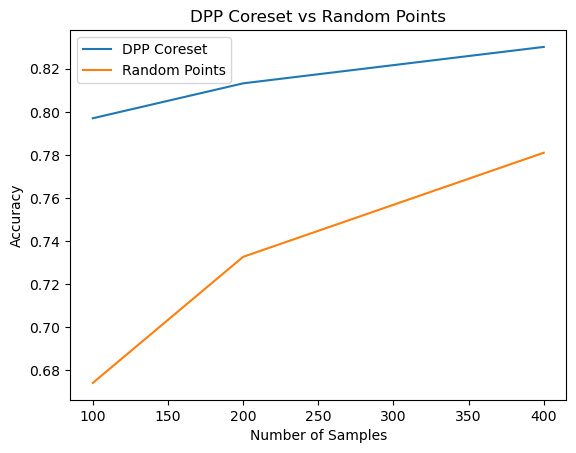

In [31]:
#plot accuraties for dpp and random points
plt.plot(size, accuracies_coreset, label='DPP Coreset')
plt.plot(size, dummy_accuracies, label='Random Points')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('DPP Coreset vs Random Points')
plt.legend()